Using device: cuda
dat shape (neurons x trials): (39209, 5900)

=== Running PCA pipeline ===
PCA: 15 components explain ≥90% variance.


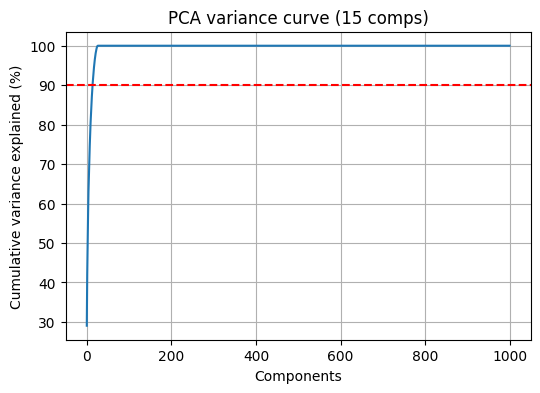

PCA: 2 / 500 significant neurons

=== Training SAE on PCA features (monosemantic expansion) ===
Epoch  10/60 | loss=0.000948
Epoch  20/60 | loss=0.001288
Epoch  30/60 | loss=0.000709
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000559
Epoch  60/60 | loss=0.000550
SAE latent shapes: train (4500, 100), test (1400, 100)
SAE: 0 / 500 significant neurons


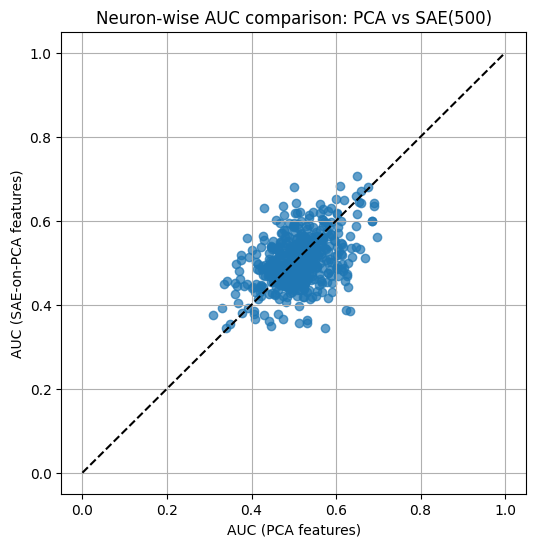


Correlation between PCA and SAE AUCs: r = 0.429


In [1]:
# ================================================================
#  PCA + Sparse Autoencoder (SAE-on-PCA) Neural Predictivity Analysis
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle, warnings, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  CLR transform
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  PCA pipeline
# ================================================================
print("\n=== Running PCA pipeline ===")
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} components explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

plt.figure(figsize=(6,4))
plt.plot(cum_var*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Components')
plt.ylabel('Cumulative variance explained (%)')
plt.title(f'PCA variance curve ({n_components_90} comps)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Logistic regressions per neuron (PCA features)
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results_pca = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue
    y_train, y_test = y[train_mask], y[test_mask]
    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue
    y_prob = model.predict_proba(X_test_pca)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)
    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)
    m_pos, n_neg = y_test.sum(), len(y_test) - y_test.sum()
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)
    results_pca.append({
        "neuron_idx": idx, "AUC": auc, "Advantage": adv,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI, "p_value": p_val
    })

df_pca = pd.DataFrame(results_pca)
reject, pvals_corrected, _, _ = multipletests(df_pca["p_value"], alpha=0.05, method="fdr_bh")
df_pca["p_adj"], df_pca["significant"] = pvals_corrected, reject
print(f"PCA: {df_pca['significant'].sum()} / {len(df_pca)} significant neurons")

# ================================================================
#  SAE trained on PCA features (monosemantic expansion)
# ================================================================
print("\n=== Training SAE on PCA features (monosemantic expansion) ===")

SAE_DIM = 100
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad()
            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# Train SAE on PCA features
X_train_clr = X_train_pca
X_test_clr  = X_test_pca
sae_model, sae_scaler = train_sae(X_train_clr)
Z_train = encode(sae_model, sae_scaler, X_train_clr)
Z_test  = encode(sae_model, sae_scaler, X_test_clr)

print(f"SAE latent shapes: train {Z_train.shape}, test {Z_test.shape}")

# ---------------------------------------------------------------
#  Logistic regressions per neuron (SAE features)
# ---------------------------------------------------------------
results_sae = []
for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue
    y_train, y_test = y[train_mask], y[test_mask]
    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(Z_train, y_train)
    except Exception:
        continue
    y_prob = model.predict_proba(Z_test)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)
    I = fisher_information_from_logreg(model, Z_train)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)
    m_pos, n_neg = y_test.sum(), len(y_test) - y_test.sum()
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)
    results_sae.append({
        "neuron_idx": idx, "AUC": auc, "Advantage": adv,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI, "p_value": p_val
    })

df_sae = pd.DataFrame(results_sae)
reject, pvals_corrected, _, _ = multipletests(df_sae["p_value"], alpha=0.05, method="fdr_bh")
df_sae["p_adj"], df_sae["significant"] = pvals_corrected, reject
print(f"SAE: {df_sae['significant'].sum()} / {len(df_sae)} significant neurons")

# ================================================================
#  Compare PCA vs SAE
# ================================================================
merged = pd.merge(df_pca[["neuron_idx","AUC","FI_along_w"]],
                  df_sae[["neuron_idx","AUC","FI_along_w"]],
                  on="neuron_idx", suffixes=("_PCA","_SAE"))

plt.figure(figsize=(6,6))
plt.scatter(merged["AUC_PCA"], merged["AUC_SAE"], alpha=0.7)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("AUC (PCA features)")
plt.ylabel("AUC (SAE-on-PCA features)")
plt.title("Neuron-wise AUC comparison: PCA vs SAE(500)")
plt.grid(True)
plt.show()

r = np.corrcoef(merged["AUC_PCA"], merged["AUC_SAE"])[0,1]
print(f"\nCorrelation between PCA and SAE AUCs: r = {r:.3f}")
